In [1]:
!pip install researchpy

In [2]:
!pip install lifetimes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
import researchpy as rp
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
from sklearn.preprocessing import MinMaxScaler
#pd.set_option('display.float_format', lambda x: '%.4f' % x)

from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv('/Users/serhandulger/flo_data_20k.csv')

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### NA SUM #####################")
    print(dataframe.isnull().sum().sum())
    print("##################### Describe #####################")
    print(dataframe.describe())
    print("##################### Nunique #####################")
    print(dataframe.nunique())

In [4]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [5]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

In [6]:
missing_values_analysis(df)

,Total Missing Values,Ratio


In [7]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["Total_Payment"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13
Total_Order,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.00
Total_Payment,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.10


In [10]:
extension = ["Total_Order","Total_Payment"]

In [11]:
num_cols = [col for col in df.columns if df[col].dtype != 'O' and col not in extension ]

In [12]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [13]:
features = ["customer_value_total_ever_online","customer_value_total_ever_offline","order_num_total_ever_offline","order_num_total_ever_online"]

In [14]:
for i in features:
    replace_with_thresholds(df,i)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.092304,3.813699,1.00,1.00,2.00,4.00,48.500
order_num_total_ever_offline,19945.0,1.886187,1.434694,1.00,1.00,1.00,2.00,16.000
customer_value_total_ever_offline,19945.0,251.921220,251.022560,10.00,99.99,179.98,319.97,3019.882
customer_value_total_ever_online,19945.0,489.705377,632.606387,12.99,149.98,286.46,578.44,7799.541
Total_Order,19945.0,5.024768,4.742707,2.00,3.00,4.00,6.00,202.000
Total_Payment,19945.0,751.244287,895.402173,44.98,339.98,545.27,897.78,45905.100


In [16]:
import datetime as dt
df["first_order_date"] = pd.to_datetime(df["first_order_date"]).dt.normalize()
df["last_order_date"] = pd.to_datetime(df["last_order_date"]).dt.normalize()
df["last_order_date_online"] = pd.to_datetime(df["last_order_date_online"]).dt.normalize()
df["last_order_date_offline"] = pd.to_datetime(df["last_order_date_offline"]).dt.normalize()

In [17]:
df.shape

(19945, 14)

In [18]:
df = df[~(df["Total_Payment"] == 0) | (df["Total_Order"] == 0)]

In [19]:
df.shape

(19945, 14)

In [20]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [21]:
today_date = dt.datetime(2021,7,1)

In [22]:
new_df = pd.DataFrame({"CUSTOMER_ID": df["master_id"],
             "RECENCY_WEEKLY": ((df["last_order_date"] - df["first_order_date"]).dt.days)/7,
             "TENURE_WEEKLY": ((today_date - df["first_order_date"]).astype('timedelta64[D]'))/7,
             "FREQUENCY": df["Total_Order"],
             "MONETARY_AVG": df["Total_Payment"] / df["Total_Order"]})

In [23]:
new_df

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,34.857143,5.0,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,229.142857,21.0,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,83.142857,5.0,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,25.142857,2.0,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,99.714286,2.0,104.990000
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.142857,92.714286,3.0,133.986667
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.285714,69.571429,2.0,195.235000
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714286,94.142857,3.0,210.980000
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.428571,118.142857,6.0,168.295000


In [24]:
##############################
# Forecasting expected purchases from customers in 3 months
##############################

In [25]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [26]:
bgf.fit(new_df['FREQUENCY'],
        new_df['RECENCY_WEEKLY'],
        new_df['TENURE_WEEKLY'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 77.58, b: 0.28, r: 3.59>

In [27]:
new_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               new_df['FREQUENCY'],
                                               new_df['RECENCY_WEEKLY'],
                                               new_df['TENURE_WEEKLY'])

In [28]:
new_df.sort_values(by="exp_sales_3_month",ascending=False)[0:10]

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG,exp_sales_3_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,71.571429,70.0,263.479571,5.920161
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,111.571429,124.000000,83.0,51.088675,5.153869
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.000000,402.857143,202.0,227.252970,5.134959
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,104.428571,124.428571,77.0,67.325325,4.775390
14402,03f502d4-a559-11e9-a2fc-000d3a38a36f,104.714286,123.000000,61.0,45.220820,3.862736
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.142857,151.428571,68.0,541.445441,3.750252
8043,4a51668a-a155-11e9-a2fc-000d3a38a36f,87.142857,103.142857,51.0,86.154118,3.624121
18067,695889b4-d6ed-11e9-93bc-000d3a38a36f,91.857143,108.142857,47.0,175.458085,3.268259
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.714286,44.285714,29.0,165.297586,3.208826
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,428.428571,436.000000,131.0,93.757557,3.144679


In [29]:
##############################
# Forecasting expected purchases from customers in 6 months
##############################

In [30]:
new_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               new_df['FREQUENCY'],
                                               new_df['RECENCY_WEEKLY'],
                                               new_df['TENURE_WEEKLY'])

In [31]:
new_df.head()

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,34.857143,5.0,187.874000,0.916444,1.832881
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,229.142857,21.0,95.883333,0.961924,1.923845
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,83.142857,5.0,117.064000,0.641106,1.282209
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,25.142857,2.0,60.985000,0.652601,1.305196
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,99.714286,2.0,104.990000,0.378144,0.756285


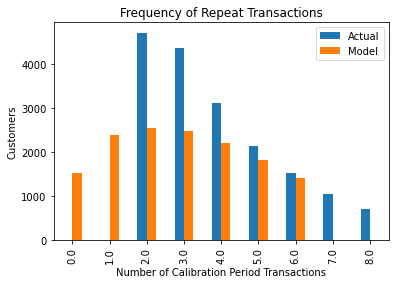

In [32]:
# prediction validation
plot_period_transactions(bgf)
plt.show()

In [33]:
##############################
# GAMMA-GAMMA MODEL 
##############################

In [34]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [35]:
ggf.fit(new_df['FREQUENCY'], new_df['MONETARY_AVG'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [36]:
new_df['EXP_AVERAGE_VALUE'] = ggf.conditional_expected_average_profit(new_df['FREQUENCY'], new_df['MONETARY_AVG'])

In [37]:
new_df.head()

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG,exp_sales_3_month,exp_sales_6_month,EXP_AVERAGE_VALUE
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,34.857143,5.0,187.874000,0.916444,1.832881,193.632763
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,229.142857,21.0,95.883333,0.961924,1.923845,96.665051
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,83.142857,5.0,117.064000,0.641106,1.282209,120.967652
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,25.142857,2.0,60.985000,0.652601,1.305196,67.320130
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,99.714286,2.0,104.990000,0.378144,0.756285,114.325181


In [38]:
##############################
# Calculation of CLTV with BG-NBD and GG model  - (6 MONTHS)
##############################

In [39]:
cltv = ggf.customer_lifetime_value(bgf,
                                   new_df['FREQUENCY'],
                                   new_df['RECENCY_WEEKLY'],
                                   new_df['TENURE_WEEKLY'],
                                   new_df['MONETARY_AVG'],
                                   time=6, # 6 MONTH
                                   freq="W",  # T's frequency information. (WEEKLY)
                                   discount_rate=0.01) # consider discounts that can be made over time (discount rate)

In [40]:
cltv = pd.DataFrame(cltv)

In [41]:
new_df["CLTV"] = cltv

In [42]:
new_df.sort_values(by='CLTV', ascending = False).head()

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG,exp_sales_3_month,exp_sales_6_month,EXP_AVERAGE_VALUE,CLTV
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857143,12.142857,4.0,5176.585000,1.014726,2.029443,5348.278535,11388.283661
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.142857,17.428571,11.0,2838.855455,1.842389,3.684766,2872.560329,11105.714543
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.142857,151.428571,68.0,541.445441,3.750252,7.500496,542.523810,4269.493742
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,71.571429,70.0,263.479571,5.920161,11.840302,264.019264,3279.940634
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,394.000000,402.857143,202.0,227.252970,5.134959,10.269913,227.416863,2450.513374


In [43]:
#########################################
# CREATING SEGMENTS BASED ON CLTV VALUES
#########################################

In [44]:
new_df["SEGMENT"] = pd.qcut(new_df["CLTV"], 4, labels=["D", "C", "B", "A"])

In [45]:
new_df.groupby("SEGMENT").agg({"count","mean","sum"})

RECENCY_WEEKLY                            TENURE_WEEKLY                            FREQUENCY                    MONETARY_AVG                           exp_sales_3_month                        exp_sales_6_month                        EXP_AVERAGE_VALUE                            CLTV                          
                 count        mean            sum         count        mean            sum     count      mean      sum        count        mean           sum             count      mean          sum             count      mean          sum             count        mean           sum count        mean           sum
SEGMENT                                                                                                                                                                                                                                                                                                                     
D                 4987  137.282277  684626.714286          4987  164.773239  821724.142857      4987  3.777822  18840.0         4987   92.694870  4.622693e+05              4987  0.394000  1964.876244              4987  0.787997  3929.742122              4987   98.254753  4.899965e+05  4987   77.223907  3.851156e+05
C                 4986   92.801788  462709.714286          4986  117.218841  584453.142857      4986  4.370437  21791.0         4986  125.995967  6.282159e+05              4986  0.502442  2505.175866              4986  1.004881  5010.337971              4986  132.484622  6.605683e+05  4986  132.507426  6.606820e+05
B                 4986   82.192167  409810.142857          4986  104.852072  522792.428571      4986  5.065183  25255.0         4986  160.887360  8.021844e+05              4986  0.573610  2860.020164              4986  1.147217  5720.024708              4986  168.285158  8.390698e+05  4986  190.896231  9.518086e+05
A                 4986   68.769326  342883.857143          4986   88.176809  439649.571429      4986  6.885880  34333.0         4986  230.031563  1.146937e+06              4986  0.745096  3715.049165              4986  1.490188  7430.078204              4986  239.171438  1.192509e+06  4986  351.018799  1.750180e+06

In [46]:
new_df.head()

,CUSTOMER_ID,RECENCY_WEEKLY,TENURE_WEEKLY,FREQUENCY,MONETARY_AVG,exp_sales_3_month,exp_sales_6_month,EXP_AVERAGE_VALUE,CLTV,SEGMENT
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,34.857143,5.0,187.874000,0.916444,1.832881,193.632763,372.375148,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,229.142857,21.0,95.883333,0.961924,1.923845,96.665051,195.122452,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,83.142857,5.0,117.064000,0.641106,1.282209,120.967652,162.740475,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,25.142857,2.0,60.985000,0.652601,1.305196,67.320130,92.190866,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,99.714286,2.0,104.990000,0.378144,0.756285,114.325181,90.718298,D


In [47]:
#########################################
# FUNCTIONALIZE ALL PROCESS
#########################################

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
import researchpy as rp
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
from sklearn.preprocessing import MinMaxScaler
#pd.set_option('display.float_format', lambda x: '%.4f' % x)

from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

In [49]:
df=pd.read_csv('/Users/serhandulger/flo_data_20k.csv')

In [50]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [51]:
def cltv_prediction(df):
    
    import datetime as dt
    df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
    df["Total_Payment"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
    
    df["first_order_date"] = pd.to_datetime(df["first_order_date"]).dt.normalize()
    df["last_order_date"] = pd.to_datetime(df["last_order_date"]).dt.normalize()
    df["last_order_date_online"] = pd.to_datetime(df["last_order_date_online"]).dt.normalize()
    df["last_order_date_offline"] = pd.to_datetime(df["last_order_date_offline"]).dt.normalize()
    
    num_cols = [col for col in df.columns if df[col].dtype != 'O' and col not in ["Total_Order","Total_Payment"]]
    
    features = ["customer_value_total_ever_online","customer_value_total_ever_offline","order_num_total_ever_offline","order_num_total_ever_online"]
    
    for i in features:
        replace_with_thresholds(df,i)
    
    df = df[~(df["Total_Payment"] == 0) | (df["Total_Order"] == 0)]
    
    today_date = dt.datetime(2021,7,1)
    
    new_df = pd.DataFrame({"CUSTOMER_ID": df["master_id"],
             "RECENCY_WEEKLY": ((df["last_order_date"] - df["first_order_date"]).dt.days)/7,
             "TENURE_WEEKLY": ((today_date - df["first_order_date"]).astype('timedelta64[D]'))/7,
             "FREQUENCY": df["Total_Order"],
             "MONETARY_AVG": df["Total_Payment"] / df["Total_Order"]})
    
    # SETTING UP BG-NBD MODEL
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    
    bgf.fit(new_df['FREQUENCY'],
        new_df['RECENCY_WEEKLY'],
        new_df['TENURE_WEEKLY'])
    
    # Expected sales frequency in 3 months
    new_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               new_df['FREQUENCY'],
                                               new_df['RECENCY_WEEKLY'],
                                               new_df['TENURE_WEEKLY'])
    
    # Expected sales frequency in 6 months
    new_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               new_df['FREQUENCY'],
                                               new_df['RECENCY_WEEKLY'],
                                               new_df['TENURE_WEEKLY'])
    
    # Prediction validation
    plot_period_transactions(bgf)
    plt.show()
    
    # SETTING UP GAMMA-GAMMA MODEL
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(new_df['FREQUENCY'], new_df['MONETARY_AVG'])
    new_df['EXP_AVERAGE_VALUE'] = ggf.conditional_expected_average_profit(new_df['FREQUENCY'], new_df['MONETARY_AVG'])
    
    cltv = ggf.customer_lifetime_value(bgf,
                                   new_df['FREQUENCY'],
                                   new_df['RECENCY_WEEKLY'],
                                   new_df['TENURE_WEEKLY'],
                                   new_df['MONETARY_AVG'],
                                   time=6, # 6 MONTH
                                   freq="W",  # T's frequency information. (WEEKLY)
                                   discount_rate=0.01) # consider discounts that can be made over time (discount rate)
    cltv = pd.DataFrame(cltv)
    new_df["CLTV"] = cltv
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(new_df[["CLTV"]])
    new_df["SCALED_CLTV"] = scaler.transform(new_df[["CLTV"]])
    
    new_df["SEGMENT"] = pd.qcut(new_df["SCALED_CLTV"], 4, labels=["D", "C", "B", "A"])
    
    final_df = pd.merge(df,new_df[["CUSTOMER_ID","CLTV","SCALED_CLTV","SEGMENT"]],left_on="master_id",right_on="CUSTOMER_ID",how="left")
    
    return df,new_df,final_df

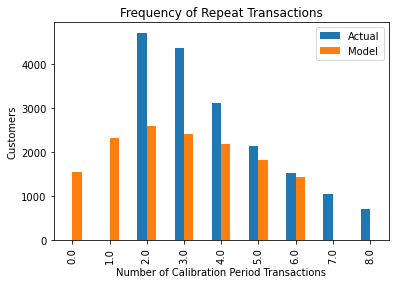

In [52]:
df,new_df,final_df  = cltv_prediction(df)

In [53]:
new_df.groupby("SEGMENT").agg({"count","mean","sum"})

RECENCY_WEEKLY                            TENURE_WEEKLY                            FREQUENCY                    MONETARY_AVG                           exp_sales_3_month                        exp_sales_6_month                        EXP_AVERAGE_VALUE                            CLTV                           SCALED_CLTV                      
                 count        mean            sum         count        mean            sum     count      mean      sum        count        mean           sum             count      mean          sum             count      mean          sum             count        mean           sum count        mean           sum       count      mean         sum
SEGMENT                                                                                                                                                                                                                                                                                                                                                       
D                 4987  137.282277  684626.714286          4987  164.773239  821724.142857      4987  3.777822  18840.0         4987   92.694870  4.622693e+05              4987  0.394000  1964.876244              4987  0.787997  3929.742122              4987   98.254753  4.899965e+05  4987   77.223907  3.851156e+05        4987  0.006779   33.804467
C                 4986   92.801788  462709.714286          4986  117.218841  584453.142857      4986  4.370437  21791.0         4986  125.995967  6.282159e+05              4986  0.502442  2505.175866              4986  1.004881  5010.337971              4986  132.484622  6.605683e+05  4986  132.507426  6.606820e+05        4986  0.011633   58.001890
B                 4986   82.192167  409810.142857          4986  104.852072  522792.428571      4986  5.065183  25255.0         4986  160.887360  8.021844e+05              4986  0.573610  2860.020164              4986  1.147217  5720.024708              4986  168.285158  8.390698e+05  4986  190.896231  9.518086e+05        4986  0.016760   83.565647
A                 4986   68.769326  342883.857143          4986   88.176809  439649.571429      4986  6.885880  34333.0         4986  230.031563  1.146937e+06              4986  0.745096  3715.049165              4986  1.490188  7430.078204              4986  239.171438  1.192509e+06  4986  351.018799  1.750180e+06        4986  0.030820  153.670426

In [56]:
final_df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,Total_Order,Total_Payment,CUSTOMER_ID,CLTV,SCALED_CLTV,SEGMENT
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],5.0,939.37,cc294636-19f0-11eb-8d74-000d3a38a36f,372.375148,0.032696,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0,2013.55,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,195.122452,0.017131,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",5.0,585.32,69b69676-1a40-11ea-941b-000d3a38a36f,162.740475,0.014288,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.0,121.97,1854e56c-491f-11eb-806e-000d3a38a36f,92.190866,0.008093,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],2.0,209.98,d6ea1074-f1f5-11e9-9346-000d3a38a36f,90.718298,0.007963,D
